### MADE RL and Advanced DL: Домашнее задание 2

Второе домашнее задание посвящено игре в крестики-нолики


![title](tictactoe.png)

### Часть первая: крестики-нолики при помощи Q-обучения

В прилагающемся коде (tictactoe.py) реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

1.	Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

2.	Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook
from tictactoe import TicTacToe, plot_test_game, get_and_print_move, plot_board

In [2]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=4)

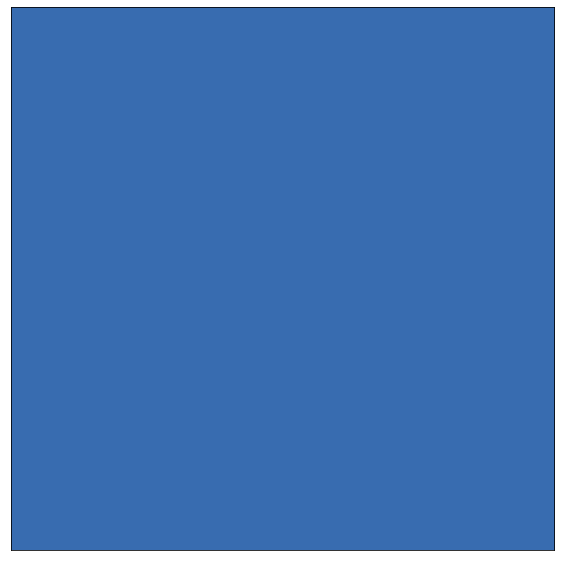

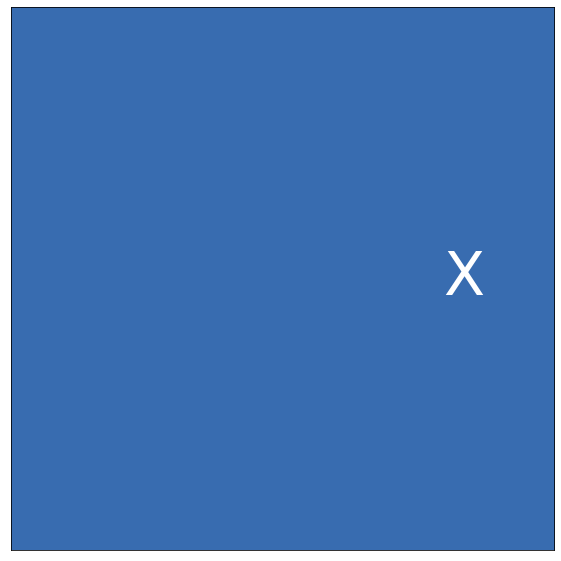

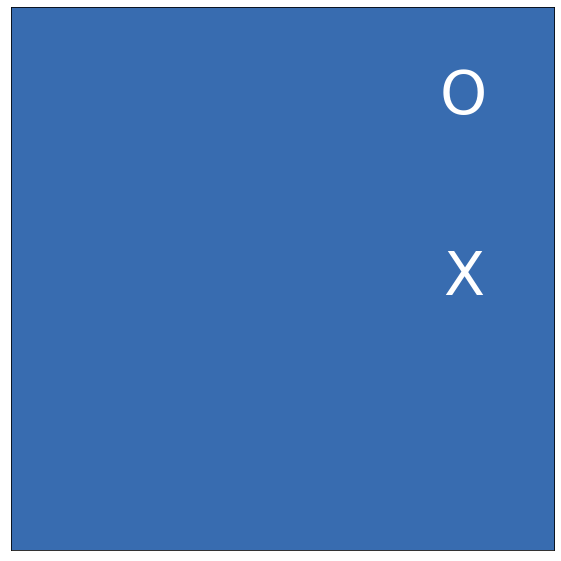

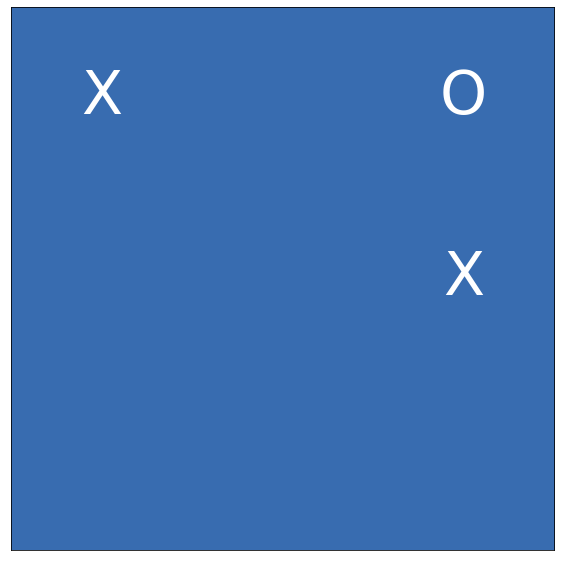

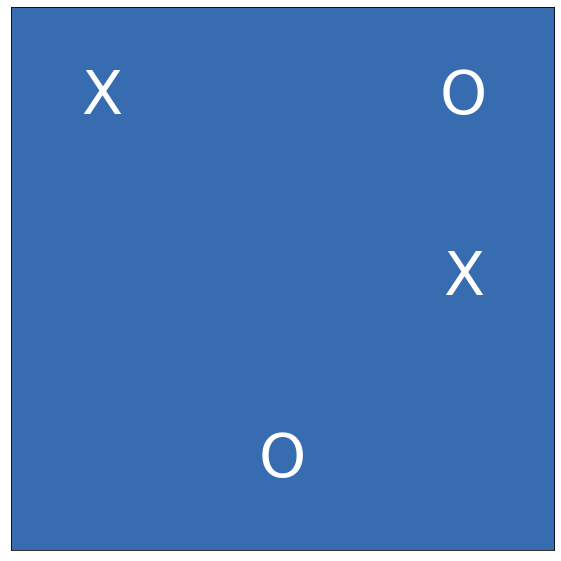

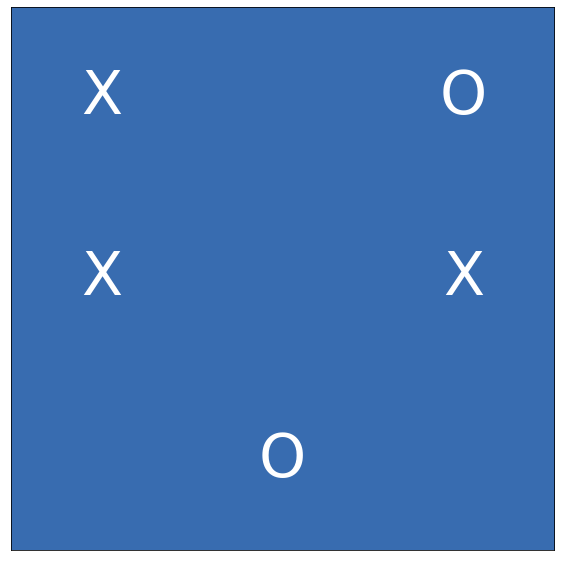

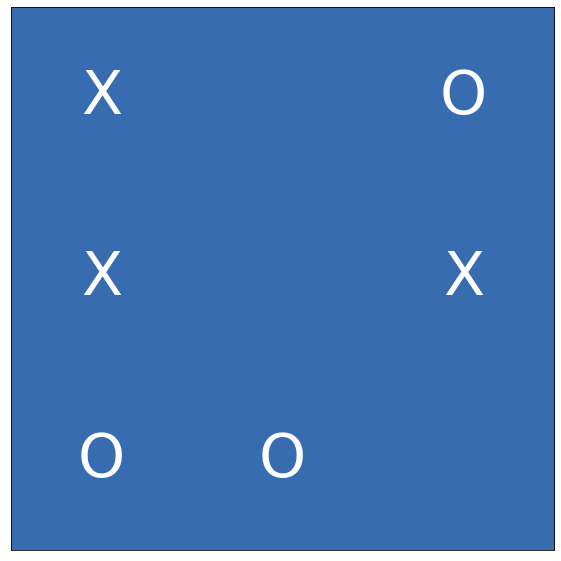

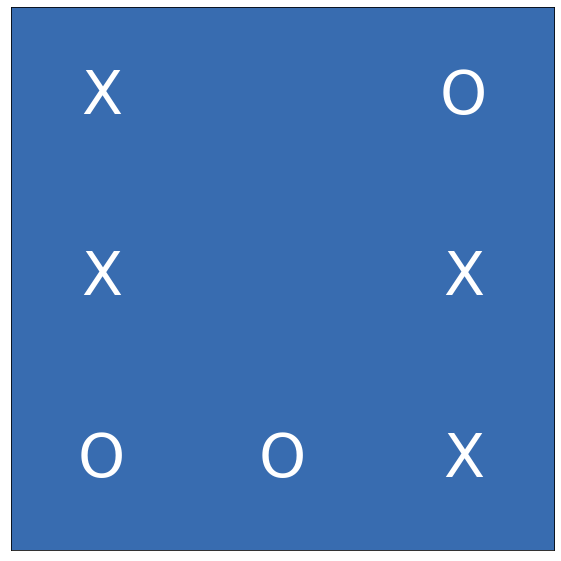

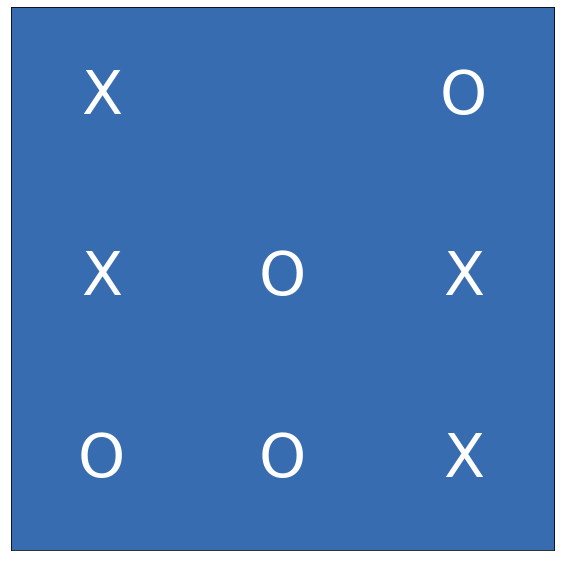

In [3]:
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

Comments about env:

Turn "1"   -- "X"

Turn "-1"  -- "O"

Actions are array of shape (N_ROWS x N_COLS, 2), where each action is array (x_coord, y_coord) on board<br>
Board hash is a string with length N_ROWS x N_COLS containig positions of "X" (2) and "O" (0) and empty cells "1". For example, hash '110111022' means:<br>
<pre>
1 1 0             -   -  "O" <br>
1 1 1      or     -   -   - <br>
0 2 2            "O" "X" "X"<br>
</pre>
"X" player makes first move.

### Q-learning functions

In [139]:
def add_state_to_Q(env, Q, verbose=False):
    if verbose:
        print(f"Q={Q}, type={type(Q)}")
    state, actions = env.getHash(), env.getEmptySpaces()
    if state not in Q.keys():
        possible_actions = [env.int_from_action(a) for a in actions]
        if len(possible_actions) > 0:
            Q[state] = np.random.random(size=len(possible_actions))
#             Q[state] = np.zeros(len(possible_actions))
        else:
            Q[state] = 0
    return Q

In [140]:
def compute_policy_by_Q(env, Q=None, epsilon=0.0, verbose=False):
    """
    Chooses actions from possible actions:
    1) If player Q values are given, chooses action which corresponds 
       to max Q value for a given state
    2) In case of random player (Q=None) chooses random action
    
    In case of zero q-value initialization
    If np.sum(Q[state]) == 0 Q-values will not update in the beggining states 
    since np.argmax(Q[state]) will always choose action_idx=0 
    
    In case of random q-value initialization use small eps to avoid same issue
    """
    state, actions = env.getHash(), env.getEmptySpaces()
    possible_actions = [env.int_from_action(a) for a in actions]
    if (Q is not None) and (state in Q.keys()) and np.sum(Q[state]) > 0 and (np.random.rand() > epsilon):
        action_idx = np.argmax(Q[state]) #idx in Q dict
        selected_action = env.action_from_int(possible_actions[action_idx])    
    else:
        action_idx = np.random.randint(len(possible_actions))
        selected_action = env.action_from_int(possible_actions[action_idx])
    if verbose:
        print(f"possible actions = {actions}\n" \
              f"possible actions indices = {possible_actions}\n" \
              f"current_state={state}\n" \
              f"selected action index = {action_idx}\n" \
              f"action = {selected_action}\n")
    return action_idx, selected_action 

In [141]:
def update_Q(env, Q, state, action_idx, reward, consider_next_state, alpha, gamma):
    """
        consider_next_state -  update Q considering next_state
        For example, after X player turn there is no need to consider next_state, 
        because player won't do move from next_state
    """
    Q[state][action_idx] += alpha * (reward - Q[state][action_idx])    
    if consider_next_state:       
        Q = add_state_to_Q(env, Q)
        next_state = env.getHash()            
        Q[state][action_idx] += alpha * (gamma * np.max(Q[next_state])) + alpha * reward
    return Q    

In [142]:
def Q_learning_episode(env, 
                       Q_x=None, 
                       Q_y=None, 
                       alpha=0.01,  
                       epsilon=0.05, 
                       gamma=1.0):
    """
    Q_x - X player
    Q_y - O player
    action is a np.array[x_coord, y_coord] where to go on board
    """
    
    env.reset() 
    done = False
    state_y = env.getHash()#"first_move"
    action_idx_y = 0
    if Q_y is not None:
         Q_y = add_state_to_Q(env, Q_y)
    while not done:
        if env.curTurn == 1:
            state_x = env.getHash()            
            # X player chooses action        
            if Q_x is None: # If X-player's actions are random
                _ , action = compute_policy_by_Q(env, None)
            else:
                Q_x = add_state_to_Q(env, Q_x)
                action_idx_x, action = compute_policy_by_Q(env, Q_x)
            
            # X player makes move
            _, reward, done, _ = env.step(action)            

            if Q_x is not None:             
                Q_x = update_Q(env, Q_x, 
                               state_x, action_idx_x, 
                               reward, consider_next_state=False, 
                               alpha=alpha, gamma=gamma)
            
            if Q_y is not None:
                Q_y = update_Q(env, Q_y, 
                               state_y, action_idx_y, 
                               -reward, consider_next_state=True, 
                               alpha=alpha, gamma=gamma)     
            
            
        elif env.curTurn == -1:           
            state_y = env.getHash()
            # O player chooses move         
            if Q_y is None: # If O-player's actions are random
                _ , action = compute_policy_by_Q(env, None)
            else:
                Q_y = add_state_to_Q(env, Q_y)
                action_idx_y, action = compute_policy_by_Q(env, Q_y)
            
            # O player makes move
            _, reward, done, _ = env.step(action)
        

            if Q_x is not None:
                Q_x = update_Q(env, Q_x, 
                               state_x, action_idx_x, 
                               reward, consider_next_state=True, 
                               alpha=alpha, gamma=gamma)
            
            if Q_y is not None:
                Q_y = update_Q(env, Q_y, 
                               state_y, action_idx_y,
                               -reward, consider_next_state=False, 
                               alpha=alpha, gamma=gamma) 
  
    return Q_x, Q_y, reward

In [143]:
def plot_mean_reward(reward_history, title=""):
    reward_x = np.where(reward_history == -1, 0, reward_history)
    reward_y = - np.where(reward_history == 1, 0, reward_history)
    b = np.cumsum(reward_x)
    mean_reward_x = b/np.arange(1, b.shape[0] + 1)
    b = np.cumsum(reward_y)
    mean_reward_y = b/np.arange(1, b.shape[0] + 1)    
    plt.figure()
    plt.plot(mean_reward_x)
    plt.plot(mean_reward_y)
    plt.legend(["reward X", "reward O"])
    plt.xlabel('Episode')
    plt.ylabel('Mean reward')
    plt.title(title)
    plt.grid()
    plt.ylim([0, 1])
    plt.show()

#### EVAL по ходу обучения

In [126]:
def learn_and_evaluate(env, Q_x, Q_y, num_of_learning_episodes=1000, num_of_eval_episodes=1000, eval_sampling=1000):
    reward_history = []
    for i in tqdm(range(num_of_episodes)):
        Q_x, Q_y, _ = Q_learning_episode(env, Q_x, Q_y, alpha=0.05, epsilon=0.05, gamma=0.9 )
        if i % eval_sampling == 0:
#             print(f"num of episode={i}")
            reward_history.append([evaluate(env, Q_x, None, num_of_eval_episodes),
                                   evaluate(env, None, Q_y, num_of_eval_episodes)])           
    return np.array(reward_history)

In [78]:
def evaluate(env, Q_x, Q_y, num_of_episodes=100):
    reward_history = []
    for _ in range(num_of_episodes):
        reward_history.append(play_episode(env, Q_x, Q_y))
    reward_history = np.array(reward_history)
    if Q_x is None:
        reward_y = - (np.where(reward_history == 1, 0, reward_history))
        return np.sum(reward_y) / num_of_episodes
    else:
        reward_x = np.where(reward_history == -1, 0, reward_history)
        return np.sum(reward_x) / num_of_episodes

In [127]:
def play_episode(env, Q_x=None, Q_y=None):
    """
    Q_x - X player
    Q_y - O player
    action is a np.array[x_coord, y_coord] where to go on board
    """    
    env.reset()
    state = env.getHash()
    done = False
    
    while not done:
        
        #X player chooses action    
        if (Q_x is None) or (state not in Q_x.keys()): 
        # Если действия X_player случайны или инструкций для текущего состояния нет
            _, action = compute_policy_by_Q(env, None)
        else:
            _, action = compute_policy_by_Q(env, Q_x, epsilon=-1)        
        # X player makes move
        _, reward, done, _ = env.step(action)
        if done:
            break
                
        # O player chooses action         
        if (Q_y is None) or (state not in Q_y.keys()): 
        # Если действия O_player случайны или инструкций для текущего состояния нет
            _, action = compute_policy_by_Q(env, None)
        else:
            _, action = compute_policy_by_Q(env, Q_y, epsilon=-1)           
        # O player makes move    
        _, reward, done, _ = env.step(action)        

    return reward

In [156]:
def plot_eval_history(reward_history, num_of_episodes, eval_sampling):
    plt.figure()
    plt.plot(np.arange(0, num_of_episodes, eval_sampling), reward_history[:, 0])
    plt.plot(np.arange(0, num_of_episodes, eval_sampling), reward_history[:, 1])
    plt.legend(["reward X", "reward O"])
    plt.xlabel('Episode')
    plt.ylabel('Mean reward')
    plt.title('Evaluation during learning')
    plt.grid()
    plt.ylim([0, 1])
    plt.xlim([0, num_of_episodes])
    plt.show()

#### Обычное Q-обучение для доски 3х3

In [144]:
%matplotlib inline

In [152]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()
"""
Set Q = None for random player
    Q = {} or learner
index x is for X-player, y is for O-player
"""
Q_x = {}
Q_y = {}

reward_history = []

num_of_episodes = int(1e4)
for _ in tqdm(range(num_of_episodes)):
    Q_x, Q_y, reward = Q_learning_episode(env, Q_x, Q_y, alpha=0.05, epsilon=0.05, gamma=0.9 )
    reward_history.append(reward)
reward_history = np.array(reward_history)

100%|██████████| 10000/10000 [00:09<00:00, 1038.53it/s]


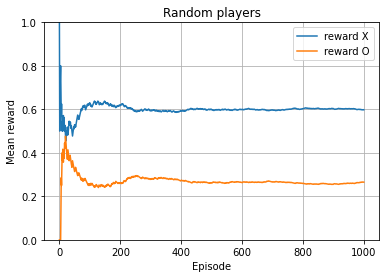

In [146]:
plot_mean_reward(reward_history[-1000:], title = "Random players")

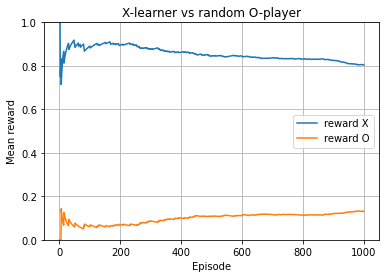

In [149]:
plot_mean_reward(reward_history[-1000:], title = "X-learner vs random O-player")

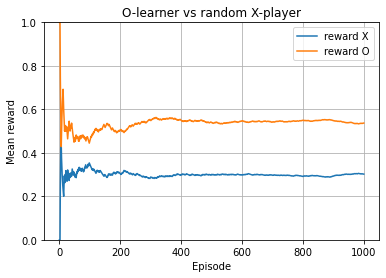

In [151]:
plot_mean_reward(reward_history[-1000:], title = "O-learner vs random X-player")

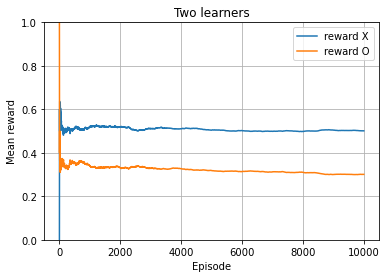

In [153]:
plot_mean_reward(reward_history[:], title = "Two learners")

Результат для двух обучающихся игроков (учатся друг с другом, оцениваются по игре со случайным противником)

100%|██████████| 100000/100000 [03:32<00:00, 470.24it/s]


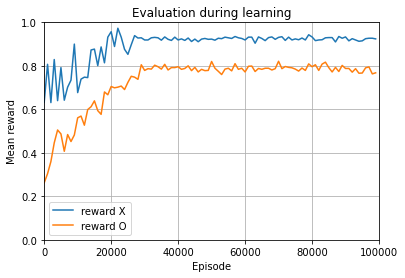

In [161]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
Q_x = {}
Q_y = {}
num_of_episodes = int(1e5)
eval_sampling = 1000
reward_history = learn_and_evaluate(env, Q_x, Q_y, num_of_learning_episodes=num_of_episodes, num_of_eval_episodes=1000, eval_sampling=eval_sampling)
plot_eval_history(reward_history, num_of_episodes, eval_sampling)

#### Обычное Q-обучение для доски 4х4

До 3 в ряд (n_win=3)

100%|██████████| 100000/100000 [07:21<00:00, 226.48it/s]


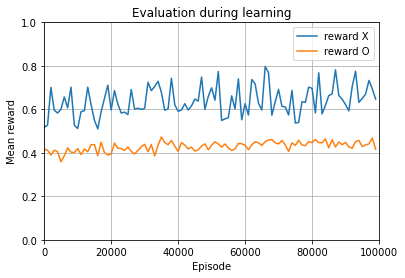

In [159]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)
"""
Set Q = None for random player
    Q = {} or learner
index x is for X-player, y is for O-player
"""
Q_x = {}
Q_y = {}

num_of_episodes = int(1e5)
eval_sampling = 1000
reward_history = learn_and_evaluate(env, Q_x, Q_y, num_of_learning_episodes=num_of_episodes, num_of_eval_episodes=1000, eval_sampling=eval_sampling)
plot_eval_history(reward_history, num_of_episodes, eval_sampling)

До 4 в ряд (n_win=4)

100%|██████████| 1000000/1000000 [1:34:19<00:00, 176.71it/s]


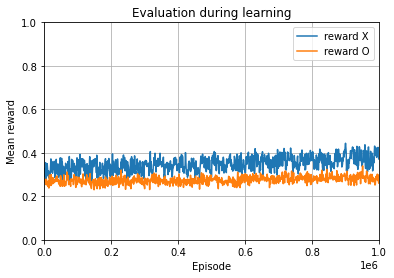

In [162]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
"""
Set Q = None for random player
    Q = {} or learner
index x is for X-player, y is for O-player
"""
Q_x = {}
Q_y = {}

num_of_episodes = int(1e6)
eval_sampling = 1000
reward_history = learn_and_evaluate(env, Q_x, Q_y, num_of_learning_episodes=num_of_episodes, num_of_eval_episodes=1000, eval_sampling=eval_sampling)
plot_eval_history(reward_history, num_of_episodes, eval_sampling)

### Часть вторая: крестики-нолики с нейросетями

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. 
Подсказка: кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

1.	Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

2.	Реализуйте Double DQN и/или Dueling DQN.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [ ]:
class ReplayMemory():
    """To avoid overfitting"""
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [ ]:
class Network(nn.Module):
    def __init__(self, inp_dim, out_dim):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(inp_dim, 256, 3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, out_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x